In [1]:
import os
import math
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.graphics.gofplots import qqplot

import matplotlib.pyplot as plt

In [2]:
base_dir=r''
os.chdir(base_dir)
df_org = pd.read_excel('Online Retail.xlsx')

In [3]:
df=df_org.copy()

In [4]:
print(df.isna().sum())
# Quantity and UnitPrice contain neg values
print('There are {0} records contain neg Quantity value and {1} records contains neg Price.'.format(len(df[df['Quantity']<0]), len(df[df['UnitPrice']<0])))

df = df[(df['Quantity']>0)&(df['UnitPrice']>0)] # remove records contain neg Quantity or neg price

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
There are 10624 records contain neg Quantity value and 2 records contains neg Price.


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4338 non-null   int64  
 1   Frequency      4338 non-null   int64  
 2   MonetaryValue  4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB
None
           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     93.059474    91.720609    2054.266460
std     100.012264   228.785094    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     307.415000
50%      51.000000    41.000000     674.485000
75%     142.750000   100.000000    1661.740000
max     374.000000  7847.000000  280206.020000
Recency          0
Frequency        0
MonetaryValue    0
dtype: int64


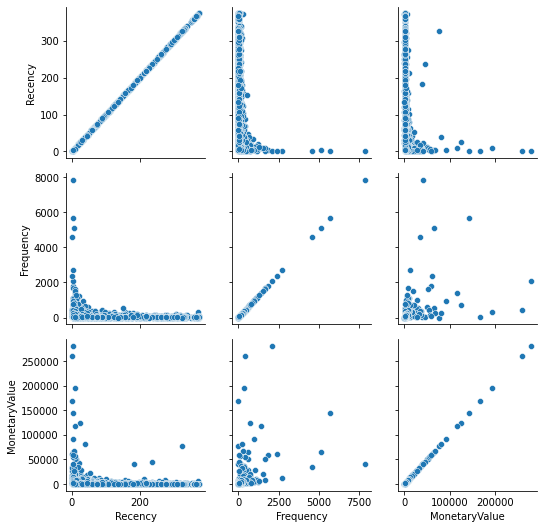

In [6]:
# Follow MFM model
# for each customer, get the most recent inovice date as the recency
#                        the number of buying as frequency, 
#                        the total sum as monetary value.
df['TotalSum']=df['Quantity']*df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
# date time to date
latest_day = max(df['InvoiceDate'] ) + datetime.timedelta(days=1)

df_customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (latest_day-x.max()).days,
    'InvoiceNo':'count',
    'TotalSum':'sum'})



df_customers.rename(columns={'InvoiceDate': 'Recency',
                             'InvoiceNo': 'Frequency',
                             'TotalSum': 'MonetaryValue'}, inplace=True)

print(df_customers.info())
print(df_customers.describe())
print(df_customers.isnull().sum())

g=sns.PairGrid(df_customers)
g.map(sns.scatterplot)

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

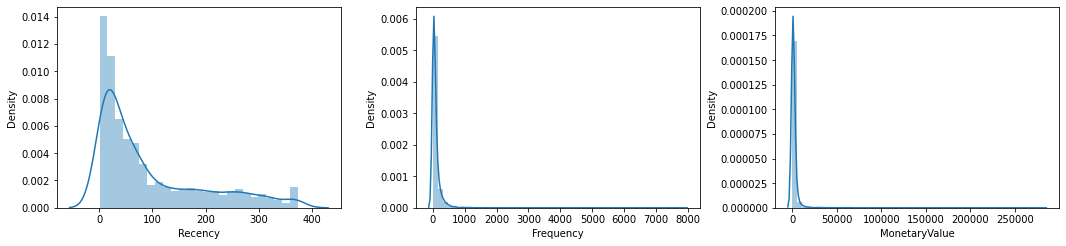

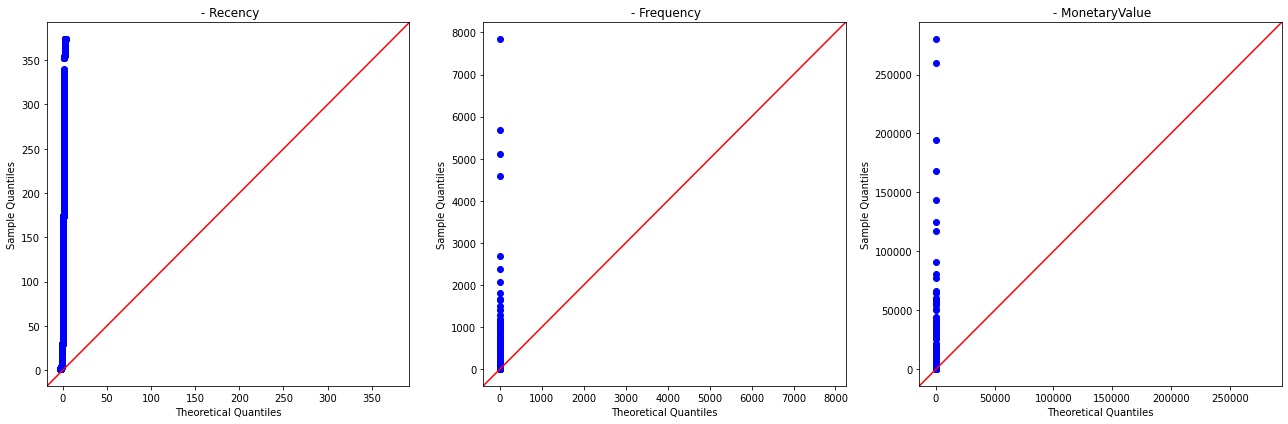

In [7]:
def show_dist(df, title=''):
    cols = [i for i in df.columns]
    plt.figure(figsize = [15, 10])
    
    for c in range(len(cols)):
        plt.subplot(3,3,c+1)
        plt.suptitle(title, size=16)
        sns.distplot(df[cols[c]])
    plt.tight_layout()
    plt.show()
    return

def show_qqplots(df, title=''):
    cols = [i for i in df.columns]
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1, 3, 1)
    qqplot(df[cols[0]], line='45', ax=ax1)
    ax1.title.set_text('{0} - {1}'.format(title, cols[0]))
    ax2 = fig.add_subplot(1, 3, 2)
    qqplot(df[cols[1]], line='45',ax=ax2)
    ax2.title.set_text('{0} - {1}'.format(title, cols[1]))
    ax3 = fig.add_subplot(1, 3, 3)
    qqplot(df[cols[2]], line='45',ax=ax3)
    ax3.title.set_text('{0} - {1}'.format(title, cols[2]))
    fig.tight_layout()
    plt.gcf()
    return 

show_dist(df_customers)
show_qqplots(df_customers)

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

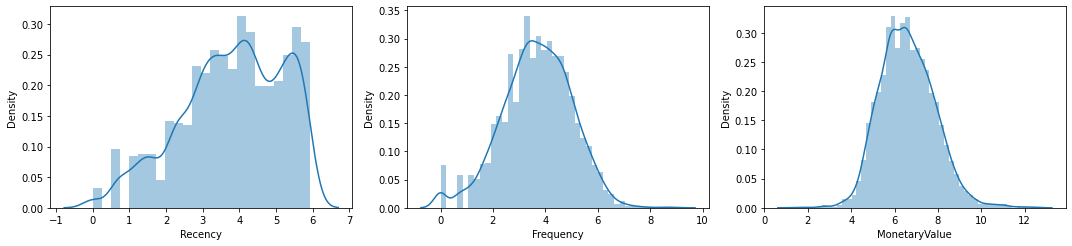

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

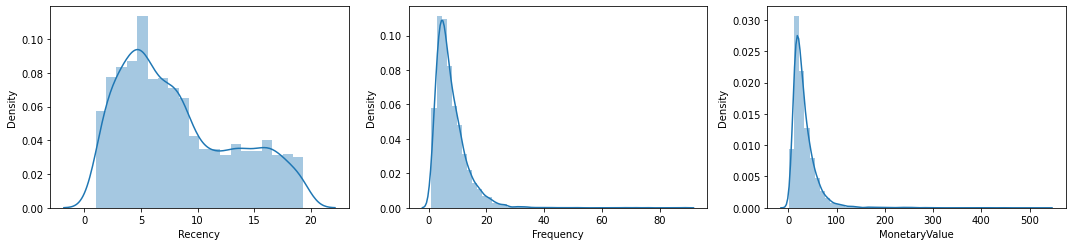

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

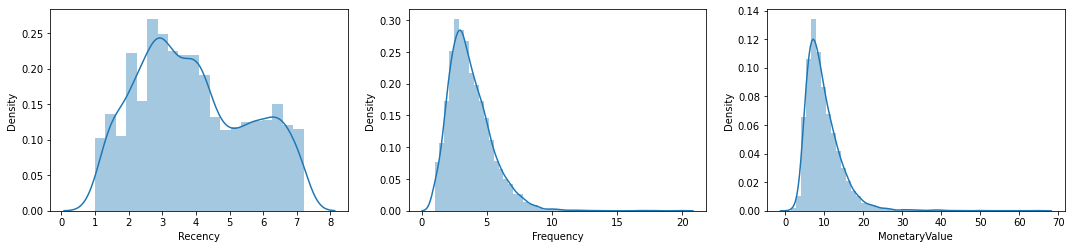

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py

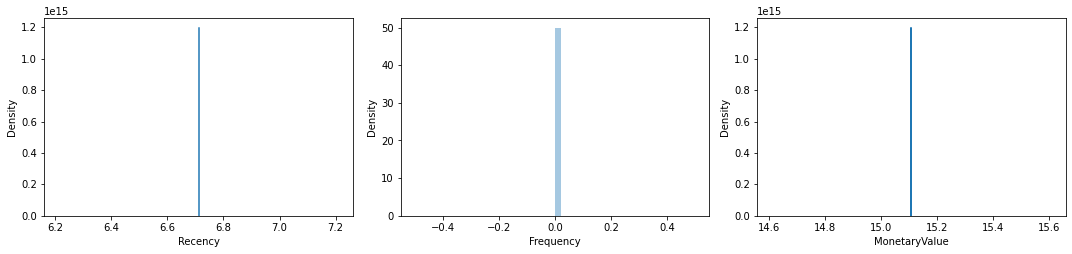

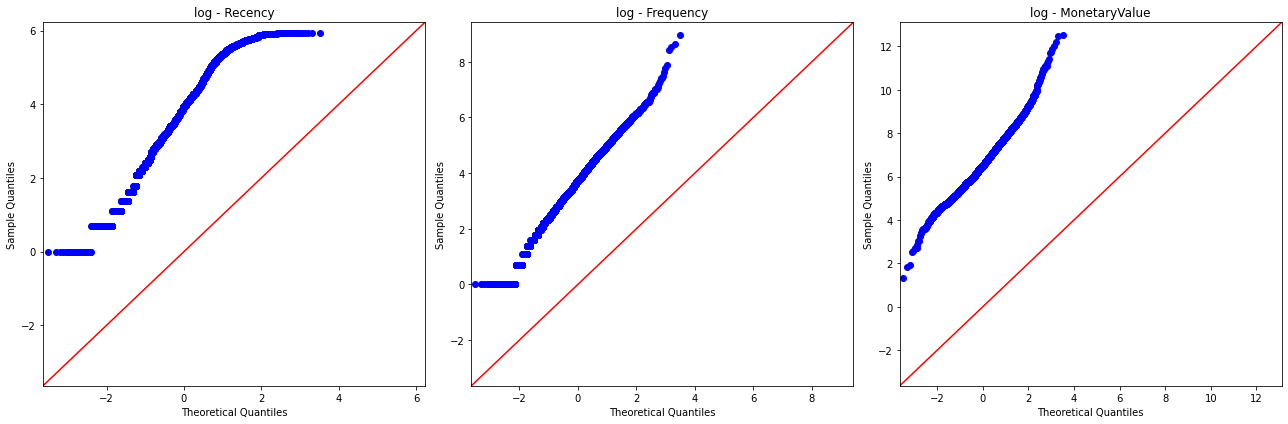

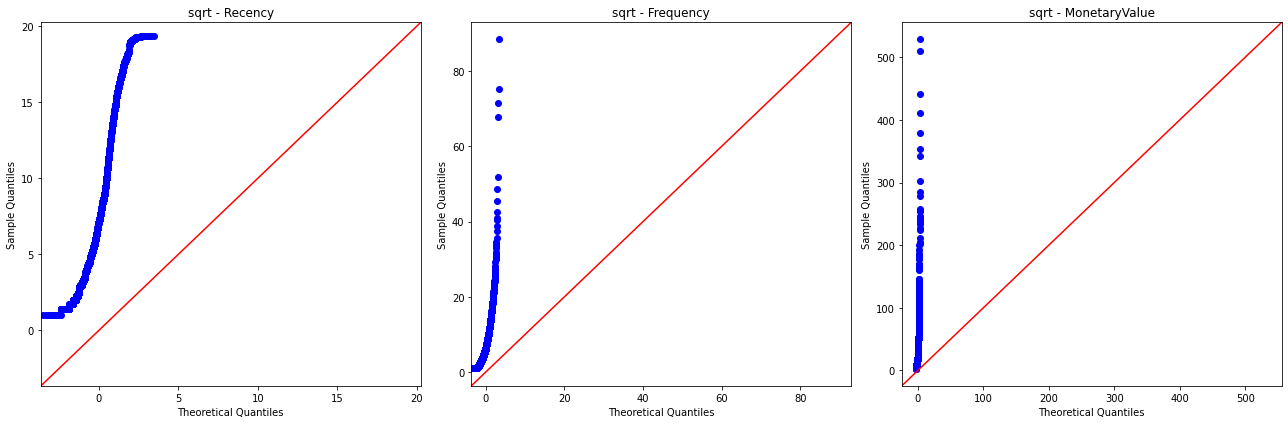

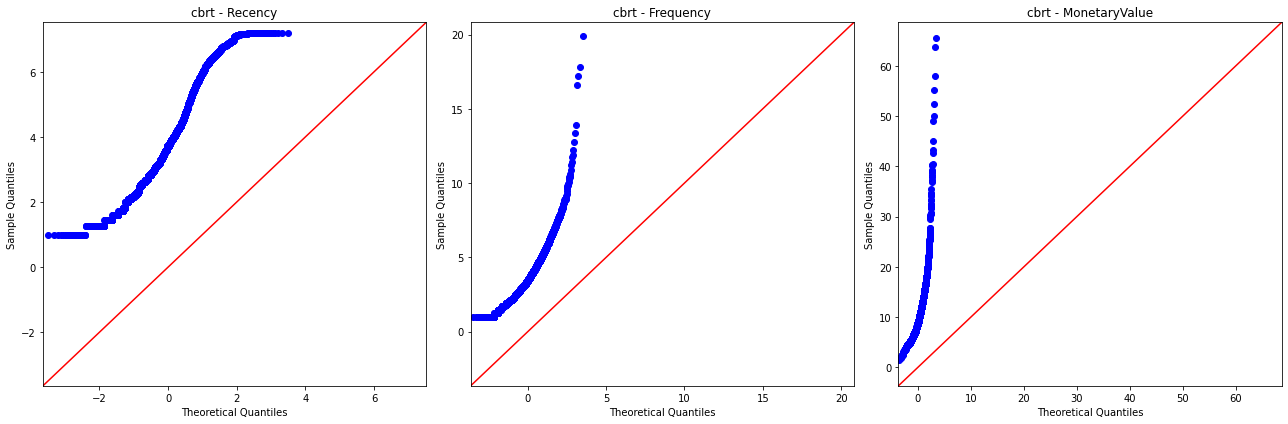

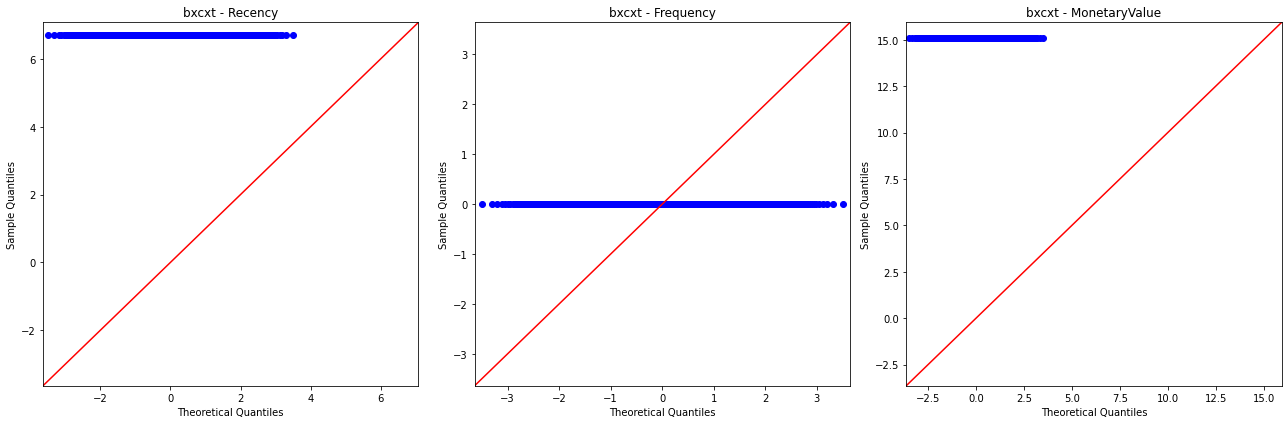

In [8]:
cols = [i for i in df_customers.columns]
cutomers_logT = df_customers.copy(deep=True) # logist  
cutomers_sqrtT = df_customers.copy(deep=True) # square root
cutomers_cbrtT = df_customers.copy(deep=True) # cube-root 
cutomers_bxcxT = df_customers.copy(deep=True) # Box-Cox power transformation, when lmbda = 0, equal to logT

for c in cols:
    cutomers_logT[c] = np.log(df_customers[c]).apply(lambda x: np.nan if x == float('-inf') else x)
    cutomers_sqrtT[c] = np.sqrt(df_customers[c])
    cutomers_cbrtT[c] = np.cbrt(df_customers[c])
    cutomers_bxcxT[c] = stats.boxcox(df_customers[c], lmbda=.05)[0]

show_dist(cutomers_logT,)
show_dist(cutomers_sqrtT)
show_dist(cutomers_cbrtT)
show_dist(cutomers_bxcxT)
show_qqplots(cutomers_logT,'log')
show_qqplots(cutomers_sqrtT,'sqrt')
show_qqplots(cutomers_cbrtT,'cbrt')
show_qqplots(cutomers_bxcxT,'bxcxt')
# still not follow normal distribution

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

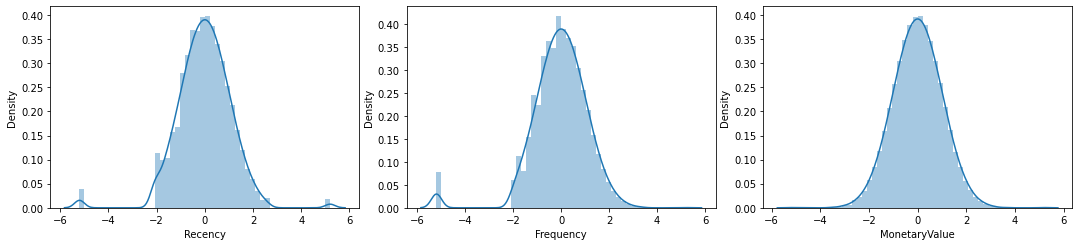

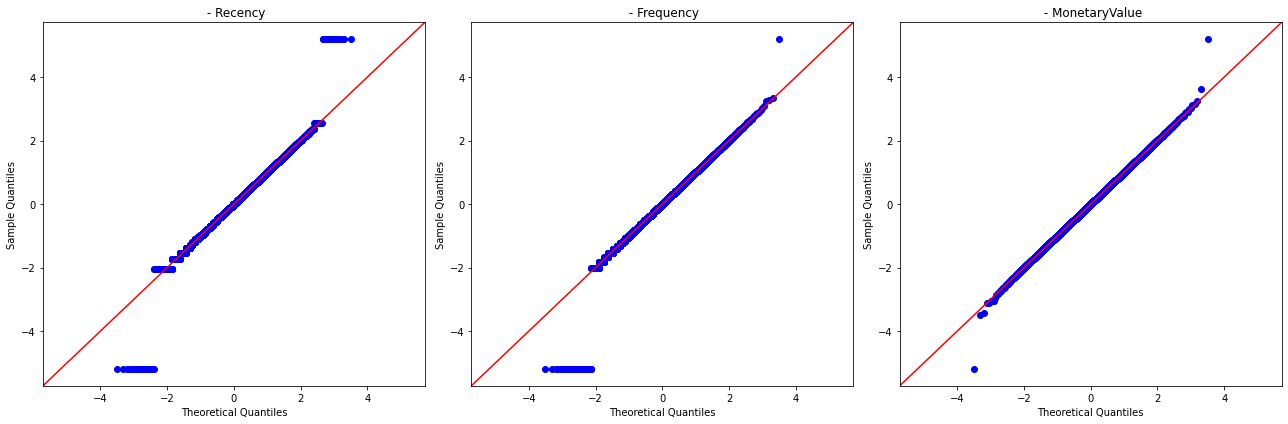

In [9]:
# still not follow normal distribution

# normal trasformation
from sklearn import preprocessing
q_transformer = preprocessing.QuantileTransformer(output_distribution='normal')
c_f = q_transformer.fit_transform(df_customers)
dfc = pd.DataFrame(c_f)
dfc.rename(columns = {0:'Recency',
                      1:'Frequency',
                      2:'MonetaryValue'}, inplace=True)


show_dist(dfc)
show_qqplots(dfc)

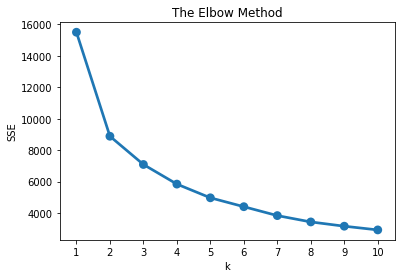

In [10]:
# k-means
# elbow
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dfc)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [11]:
model = KMeans(n_clusters=5)
model.fit(dfc)
dfc['label']=model.labels_

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


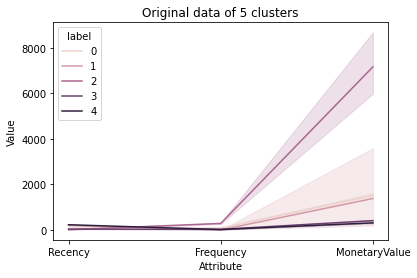

C:\Users\xurui\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


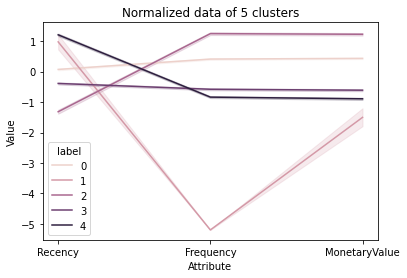

In [12]:
df1 = df_customers.copy(deep=True)
df1['label']=model.labels_

df2 = df1.groupby('label').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
df2

# original data
df3 = pd.melt(df1.reset_index(), id_vars=['label'], 
              value_vars=['Recency','Frequency','MonetaryValue'],
              var_name='Attribute',value_name='Value')
sns.lineplot('Attribute', 'Value', hue='label', data=df3)
plt.title('Original data of 5 clusters')
plt.show()
# normalized data
df4 = pd.melt(dfc.reset_index(), id_vars=['label'], 
              value_vars=['Recency','Frequency','MonetaryValue'],
              var_name='Attribute',value_name='Value')
sns.lineplot('Attribute', 'Value', hue='label', data=df4)
plt.title('Normalized data of 5 clusters')
plt.show()